In [33]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pprint
import openpyxl
import ast
from scipy.stats import ttest_ind
import statsmodels.api as sm
from scipy.stats import shapiro
import scipy.stats as stats
from scipy.stats import chi2_contingency

from matplotlib import font_manager


font_fname = 'C:/Windows/Fonts/malgun.ttf'
font_family = font_manager.FontProperties(fname=font_fname).get_name()

plt.rcParams["font.family"] = font_family
plt.rcParams["axes.unicode_minus"] = False

### Spotify의 wed_API로 데이터 수집
- spotify에서 제공하는 spotipy 라는 라이브러리를 이용

In [83]:
# key_1
# client_credentials_manager = SpotifyClientCredentials(client_id='e48676801c514fd0a6202eb890eaa0f1', client_secret='14d81002649d483f9002f027f575a80d')

# key_2
# client_credentials_manager = SpotifyClientCredentials(client_id='5022af45601e4149a0881fbbe27eef62', client_secret='e8927574ef474d15aec854bcdbb6894d')

# key_3
client_credentials_manager = SpotifyClientCredentials(client_id='f588ee129cec4da4a194ece6210ffab6', client_secret='87a162c57c234a43abb6e604c7da8c2c')

sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

### 사용 함수

In [84]:
# album_id_search 검색 album_id또는 트랙들id 받기
def album_id_search(albums_id):
    """엘범의 아이디를 최대 20개씩 spotipy를 통해 불러와, 
    엘범 이름과 그 엘범의 수록된 track의 id를 가져온다.

    Args:
        albums_id (STR in list): 엘범의 id를 리스트에

    Returns:
        딕셔너리: {album_name : tracks_id}
    """
    resert = {'album_id': [],
              'album_name': [],
              'album_tracks': []}
    batch_size = 20
    for i in range(0, len(albums_id), batch_size):        
        batch_album_ids = albums_id[i:i+batch_size]
        albums = sp.albums(batch_album_ids)['albums']
        
        for album in albums:
            album_tracks_id = []
            total = album['total_tracks']
            if total > 0: 
                resert['album_name'].append(album['name'])
                resert['album_id'].append(album['id'])
                for track in album['tracks']['items']:
                    album_tracks_id.append(track['id'])
                resert['album_tracks'].append(album_tracks_id)
    return resert

In [85]:
# playlist_id  playlist의 이름과 track_id를 리스트로 받은 후 이름을 key로 dict를 만들어 반환함.

def playlist_id(ids):
    """
    단일 playlist의 id로 검색하며,
    playlist의 name과 track들의 id를 dict로 반환해줍니다.

    Args:
        ids (list): playlist_id list를 입력해야한다.

    Returns:
        dict: 검색된 playlist의 neme이 key, track_id가 value인 dict
    """
    
    id_date = {}
    
    for id in ids:
        id_list = []
        offset = 0
        limit = 100
        while True:
            playlist = sp.playlist_tracks(id, limit=limit, offset=offset)
            tracks = playlist['items']
            for item in tracks:
                track_id = item['track']['id']
                id_list.append(track_id)
        
            
            offset += limit
            if len(tracks) < limit:
                break
             
        playlist_name = sp.playlist(id)['name']
        id_date[playlist_name] = id_list
        
        
    return id_date

In [86]:
# track_id_search track 정보 가져오기

def track_id_search(ids, DF=True, give_artist_id=False, give_album_id=False):
    """track의 id로 트렉의 정보를 받아옵니다.
    설정에 따라 DataFrame으로 받거나 dict로 받을 수 있습니다.
    설정에 따라 artist_id의 리스트를 받을 수 있습니다.
    설정에 따라 album_id의 리스트를 받을 수 있습니다.

    Args:
        ids (list): 트랙의 id를 리스트형태로 입력해야합니다. 각 ID는 STR타입으로 입력해야합니다.
        DF (bool, optional): 데이터를 DataFrame으로 받을지 Dict로 받을지 선택할 수 있습니다. Defaults to True.
        give_artist_id (bool, optional): artist_id_list를 받을 수 있습니다. 중복은 없습니다. Defaults to False.
        give_album_id (bool, optional): artist_id_list를 받을 수 있습니다. 중복은 없습니다. Defaults to False.

    Returns:
        tuple: track의 정보를 DataFrame 객체 또는 사전(dict)을 반환할 수 있습니다. 또 추가적인 조건에 따라 artist_id와 album_id를 결과값으로 반환할 수도 있습니다.
               artist_id가 두번째로, album_id가 세번째로 반환됩니다.
    """
    
    track_data = {'track_id': ids,
                'track_name': [],
                'track_popularity': [],
                'album_id': []}
    
    return_data = []
    batch_size = 20
    
    if give_artist_id == True:
        artist_id_list = []
        for i in range(0, len(ids), batch_size):
            batch_album_ids = ids[i:i+batch_size]
            tracks = sp.tracks(batch_album_ids)['tracks']
            for track in tracks:
                track_data['track_name'].append(track['name'])
                track_data['track_popularity'].append(track['popularity'])
                track_data['album_id'].append(track['album']['id'])
                for j in range(len(track['artists'])):
                    artist_id_list.append(track['artists'][j]['id']) 
                    
        return_data.append(list(set(artist_id_list))) 
                                        
    else:                    
        for i in range(0, len(ids), batch_size):
            batch_album_ids = ids[i:i+batch_size]
            tracks = sp.tracks(batch_album_ids)['tracks']
            for track in tracks:
                track_data['track_name'].append(track['name'])
                track_data['track_popularity'].append(track['popularity'])
                track_data['album_id'].append(track['album']['id'])


    if give_album_id == True:
        return_data.append(list(set(track_data['album_id'])))


    if DF == True:
        track_data = pd.DataFrame(track_data)
    
    return_data.insert(0,track_data)   
    if give_album_id == True or give_artist_id == True:
        return tuple(return_data)
        
    return track_data

In [87]:
# details_to_df 트렉의 특징 받아오기.

def details_to_df(ids):
    """track의 id로 track features를 받아옴 최대 20개씩 받아옴.

    Args:
        ids (list): track의 id를 리스트로 저장해둔 변수

    Returns:
        DataFrame: track features를 DF형태로 반환함.
                   columns = ['track_id', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
    """
    track_features = []
    batch_size = 50
    for i in range(0, len(ids), batch_size):
        batch_track_ids = ids[i:i + batch_size]
        batch_af = sp.audio_features(batch_track_ids)
        if batch_af is not None:
            track_features.extend([af for af in batch_af if af is not None])
    
    track_details_df = pd.DataFrame(track_features)
    track_details_df = track_details_df[['id', 'danceability', 'energy', 'loudness', 'speechiness',
                                         'acousticness', 'instrumentalness', 'liveness', 'valence',
                                         'tempo', 'duration_ms']]
    track_details_df.columns = ['track_id', 'danceability', 'energy', 'loudness', 'speechiness',
                                'acousticness', 'instrumentalness', 'liveness', 'valence',
                                'tempo', 'duration_ms']
    
    return track_details_df

In [88]:
# search_track_id_year 특정년도 음악 트렉 아이디만

def search_track_id_year(number, year=2021):
    """track_id를 연도기준으로 가져옵니다.

    Args:
        number (int): 가져올 트랙 개수입니다.
        year (int, optional): 연도 설정입니다. Defaults to 2021.

    Returns:
        list: track_id를 리스트로 반환합니다.
    """
    track_id =[]
    for i in range(0,number,50):
        track_results = sp.search(q=f'year:{year}', type='track', limit=50, offset=i)
        for i, t in enumerate(track_results['tracks']['items']):
            track_id.append(t['id'])
    return track_id


In [89]:
def show_plot(df):
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 6))
    details = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'track_popularity']

    for i, detail in enumerate(details):
        row = i // 5
        col = i % 5
        
        axes[row, col].hist(df[detail], bins=10, alpha=0.5)
        axes[row, col].set_xlabel(detail)
        axes[row, col].set_ylabel('Count')

        

    plt.tight_layout()
    plt.show()

In [90]:
# instrumentalness(보컬의 정도), loudness(청각 듣는정도), acousticness(반주구간)
def detail_filt(df):
    details = ['energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'track_popularity']
    for detail in details:
        df = df[df[detail] != 0]
    
    return df

### 데이터 수집

#### 대중 음악

In [91]:
track_id_list = []
for i in range(2012,2023):
    track_id_list.extend(search_track_id_year(1000, year=i))

In [92]:
track_11000_df = track_id_search(track_id_list)
track_11000_df.to_csv('track_11000_df.csv', index=False)

In [5]:
track_11000_df = pd.read_csv('track_11000_df.csv')

In [6]:
print(track_11000_df.shape)
track_11000_df.head()

(11000, 4)


,track_id,track_name,track_popularity,album_id
0,2HbKqm4o0w5wEeEFXm2sD4,Money Trees,84,6PBZN8cbwkqm1ERj2BGXJ1
1,01Lr5YepbgjXAWR9iOEyH1,Love Sosa,84,2B4y3j02ho6XNF8BEzx3JF
2,3GZD6HmiNUhxXYf8Gch723,Lost,86,392p3shh2jkxUxY2VHvlH8
3,0nJW01T7XtvILxQgC5J7Wh,When I Was Your Man,89,58ufpQsJ1DS5kq4hhzQDiI
4,3w3y8KPTfNeOKPiqUTakBh,Locked out of Heaven,88,58ufpQsJ1DS5kq4hhzQDiI


In [7]:
track_11000_df.sort_values('track_popularity').head(2)

,track_id,track_name,track_popularity,album_id
938,0a3T2HEIV4jTjhzNkM6eRx,High For This,50,3MP8mUHuQlYrGUkrEG4qpJ
933,1dAHj1Z2jfYh6iN59WZ7Oj,Thursday,50,3MP8mUHuQlYrGUkrEG4qpJ


##### 인기도 50이하의 곡도 수집

In [96]:
track_album = track_11000_df['album_id'].tolist()
track_album = list(set(track_album))
len(track_album)

6165

In [97]:
album_11000 = album_id_search(track_album)
album_11000_df = pd.DataFrame(album_11000)
album_11000_df.to_csv('album_11000_df.csv', index=False)

In [8]:
album_11000_df = pd.read_csv('album_11000_df.csv')

In [9]:
album_id_list = album_11000_df['album_id'].tolist()
album_tracks = album_11000_df['album_tracks'].tolist()

# eval() 함수를 리스트가 통째로 문자열인것을 리스트로 변환
converted_list = [ast.literal_eval(track) for track in album_tracks]

album_tracks_list = []
for t in zip(album_id_list, converted_list):
    album_tracks_list.append({"album_id": t[0], "album_tracks": t[1]} )
    
    
    
album_tracks_df = pd.json_normalize(album_tracks_list, record_path=("album_tracks"), meta=["album_id"])
album_tracks_df = album_tracks_df.rename(columns={0:'album_track'})
album_tracks_df.head()

,album_track,album_id
0,3Qw9krq5EC7VPaa6QmbcuH,7weU5IWFfeueNG5V68CTTT
1,3Qe097eJNp9MfpT2PieEw0,7weU5IWFfeueNG5V68CTTT
2,13dQb9ZXU7ehRoDLrjyTt0,7weU5IWFfeueNG5V68CTTT
3,0lkte5wif8KIuWYYPw7yZo,7weU5IWFfeueNG5V68CTTT
4,0drTByxQx8aMHzotZG3LDS,7weU5IWFfeueNG5V68CTTT


In [10]:
album_tracks_df.shape

(57817, 2)

In [101]:
all_57817_df = track_id_search(album_tracks_df['album_track'])
all_57817_df.to_csv('all_57817_df.csv',index=False)

In [11]:
all_57817_df = pd.read_csv('all_57817_df.csv')

In [12]:
all_57817_df['대중음악'] = 1
all_57817_df['게임음악'] = 0

In [104]:
all_57817_detail_df = details_to_df(all_57817_df['track_id'])
all_57817_detail_df.to_csv('all_57817_detail_df.csv',index=False)

In [2]:
all_57817_detail_df = pd.read_csv('all_57817_detail_df.csv')

In [13]:
all_57817_merge = pd.merge(all_57817_detail_df, all_57817_df[['track_id', '대중음악','게임음악','track_popularity']], on='track_id', how='left')

In [14]:
all_57817_merge.sort_values('duration_ms', ascending=False).head(3)

,track_id,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,대중음악,게임음악,track_popularity
44562,4ETPfRDXU6xLKotEVcoMB4,0.472,0.677,-7.964,0.0632,0.277,0.000024,0.102,0.467,116.054,4050759,1,0,25
30911,2s63mIt5K7c4EKwO1cSNLi,0.614,0.703,-7.134,0.9480,0.823,0.000000,0.260,0.488,68.873,1665544,1,0,10
5882,1H2KZ21IWEEhjoVyqS10S8,0.563,0.239,-19.836,0.9270,0.917,0.000000,0.311,0.456,87.245,1549965,1,0,42


#### 목적에 맞지않는 값 제거

In [15]:
# 게임 음악이 아닌 효과음
all_57817_merge_filt = all_57817_merge[all_57817_merge['duration_ms'] <= 360000]

# 하나의 트랙이 아닌 여러 트랙을 연결해놓은 곡
all_57817_merge_filt = all_57817_merge_filt[all_57817_merge_filt['duration_ms'] >= 90000]

In [16]:
# 결측값 제거
all_57817_merge_filt2 = all_57817_merge_filt[all_57817_merge_filt['track_popularity'] != 0]

#### 게임 음악

In [110]:
# 플레이리스트 4개에서 음악 전부 가져오기
game_playlist = ['3BGckoXAM2qE5Hb2zWbIiX', '0uBPX5ktAhWU48VSRhTNic', '37i9dQZF1DXdfOcg1fm0VG','06saXsaZA818xjQmA6t9Ee']
playlist_track_id = playlist_id(game_playlist)
playlist_track_id.keys()

In [111]:
print(
len(playlist_track_id['Game Soundtracks (200+ Games)']),
len(playlist_track_id['Game Soundtrack']),
len(playlist_track_id['Video Game Soundtracks']),
len(playlist_track_id['Game Soundtracks']))

In [112]:
playlist_track_ids = list(set(
                        playlist_track_id['Game Soundtracks (200+ Games)'] +
                        playlist_track_id['Game Soundtrack'] +
                        playlist_track_id['Video Game Soundtracks'] +
                        playlist_track_id['Game Soundtracks']))

In [113]:
# 100번씩 루프하면서 트랙들을 받아오는데 401번째에 트랙 1개 뿐이라 구조가 달라져서 None값이 들어감
playlist_track_ids = [x for x in playlist_track_ids if x is not None]
# 빠진 트랙 추가
playlist_track_ids.append('6GdesCf6pwGGTWIsa9RWHB')

In [114]:
playlist_track_df = track_id_search(playlist_track_ids)
playlist_track_df.to_csv('playlist_track_df.csv', index=False)

In [115]:
playlist_track_df = pd.read_csv('playlist_track_df.csv')

In [116]:
playlist_album = playlist_track_df['album_id'].tolist()
playlist_album = list(set(playlist_album))
len(playlist_album)

847

In [117]:
playlist_tracks = album_id_search(playlist_album)
playlist_tracks_df = pd.DataFrame(playlist_tracks)
playlist_tracks_df.to_csv('playlist_tracks_df.csv', index=False)

In [118]:
playlist_tracks_df = pd.read_csv('playlist_tracks_df.csv')

In [120]:
album_id_list = playlist_tracks_df['album_id'].tolist()
converted_list = playlist_tracks_df['album_tracks'].tolist()

# eval() 함수를 리스트가 통째로 문자열인것을 리스트로 변환
converted_list = [ast.literal_eval(track) for track in album_tracks]

album_tracks_list = []
for t in zip(album_id_list, converted_list):
    album_tracks_list.append({"album_id": t[0], "album_tracks": t[1]} )
    
album_tracks_df = pd.json_normalize(album_tracks_list, record_path=("album_tracks"), meta=["album_id"])
album_tracks_df = album_tracks_df.rename(columns={0:'album_track'})
album_tracks_df.head()

,album_track,album_id
0,3Qw9krq5EC7VPaa6QmbcuH,7cTbjqfofNfUq5eIlicTXk
1,3Qe097eJNp9MfpT2PieEw0,7cTbjqfofNfUq5eIlicTXk
2,13dQb9ZXU7ehRoDLrjyTt0,7cTbjqfofNfUq5eIlicTXk
3,0lkte5wif8KIuWYYPw7yZo,7cTbjqfofNfUq5eIlicTXk
4,0drTByxQx8aMHzotZG3LDS,7cTbjqfofNfUq5eIlicTXk


In [ ]:
game_track_df = track_id_search(album_tracks_df['album_track'])
game_track_df.to_csv('game_track_df.csv', index=False)

In [22]:
game_track_df = pd.read_csv('game_track_df.csv')

In [23]:
game_track_df['대중음악'] = 0
game_track_df['게임음악'] = 1

In [ ]:
game_detail_df = details_to_df(game_track_df['track_id'])
game_detail_df.to_csv('game_detail_df.csv', index=False)

In [24]:
game_detail_df = pd.read_csv('game_detail_df.csv')

In [25]:
game_detail_merge = pd.merge(game_detail_df, game_track_df[['track_id', '대중음악','게임음악','track_popularity']], on='track_id', how='left')

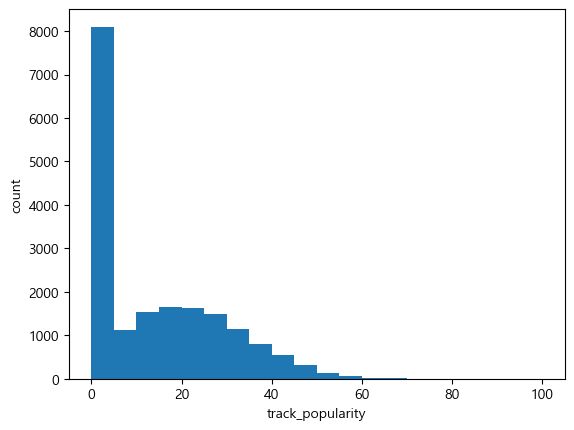

In [26]:
bin = [i for i in range(0,101,5)]
game_detail_merge['track_popularity'].plot.hist(bins=bin)
plt.ylabel('count')
plt.xlabel('track_popularity')
plt.show()

In [27]:
game_detail_merge_filt = game_detail_merge[game_detail_merge['duration_ms'] <= 360000]
game_detail_merge_filt = game_detail_merge_filt[game_detail_merge_filt['duration_ms'] >= 90000]

In [28]:
game_detail_merge_filt2 = game_detail_merge_filt[game_detail_merge_filt['track_popularity'] != 0]

Text(0, 0.5, 'count')

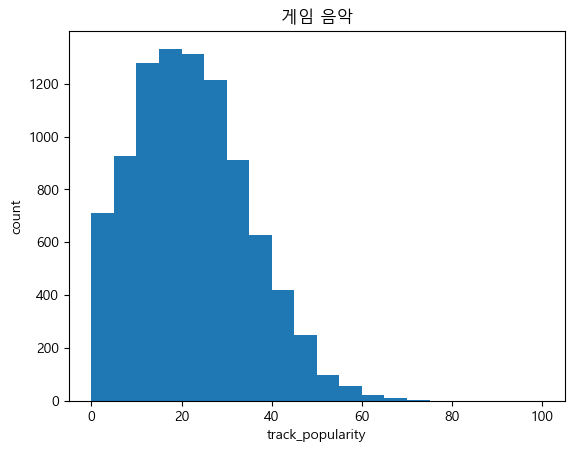

In [128]:
bin = [i for i in range(0,101,5)]
game_detail_merge_filt2['track_popularity'].plot.hist(bins=bin)
plt.title('게임 음악')
plt.xlabel('track_popularity')
plt.ylabel('count')

### 두 데이터를 합침.

In [129]:
game_57817_df = pd.concat([all_57817_merge_filt2, game_detail_merge_filt2], axis=0, ignore_index=True)
game_57817_df.to_csv('game_57817_df.csv', index=False)

In [31]:
game_57817_df = pd.read_csv('game_57817_df.csv')

### 변수 분석

In [131]:
game_57817_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62940 entries, 0 to 62939
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          62940 non-null  object 
 1   danceability      62940 non-null  float64
 2   energy            62940 non-null  float64
 3   loudness          62940 non-null  float64
 4   speechiness       62940 non-null  float64
 5   acousticness      62940 non-null  float64
 6   instrumentalness  62940 non-null  float64
 7   liveness          62940 non-null  float64
 8   valence           62940 non-null  float64
 9   tempo             62940 non-null  float64
 10  duration_ms       62940 non-null  int64  
 11  대중음악              62940 non-null  int64  
 12  게임음악              62940 non-null  int64  
 13  track_popularity  62940 non-null  int64  
dtypes: float64(9), int64(4), object(1)
memory usage: 6.7+ MB


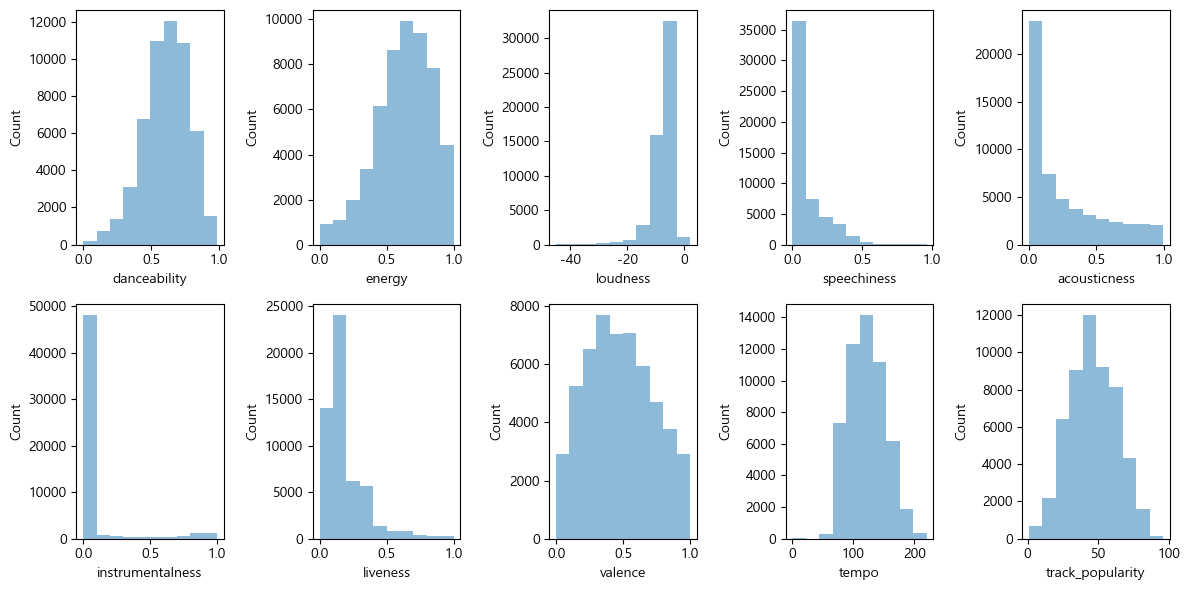

In [132]:
show_plot(all_57817_merge_filt2)

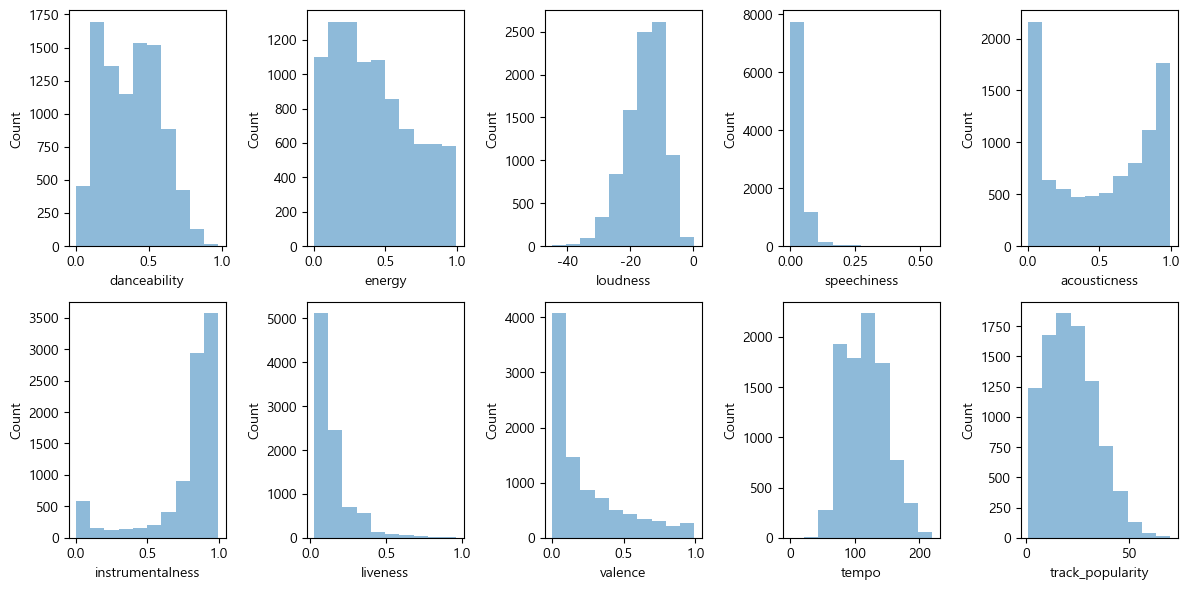

In [ ]:
show_plot(game_detail_merge_filt2)

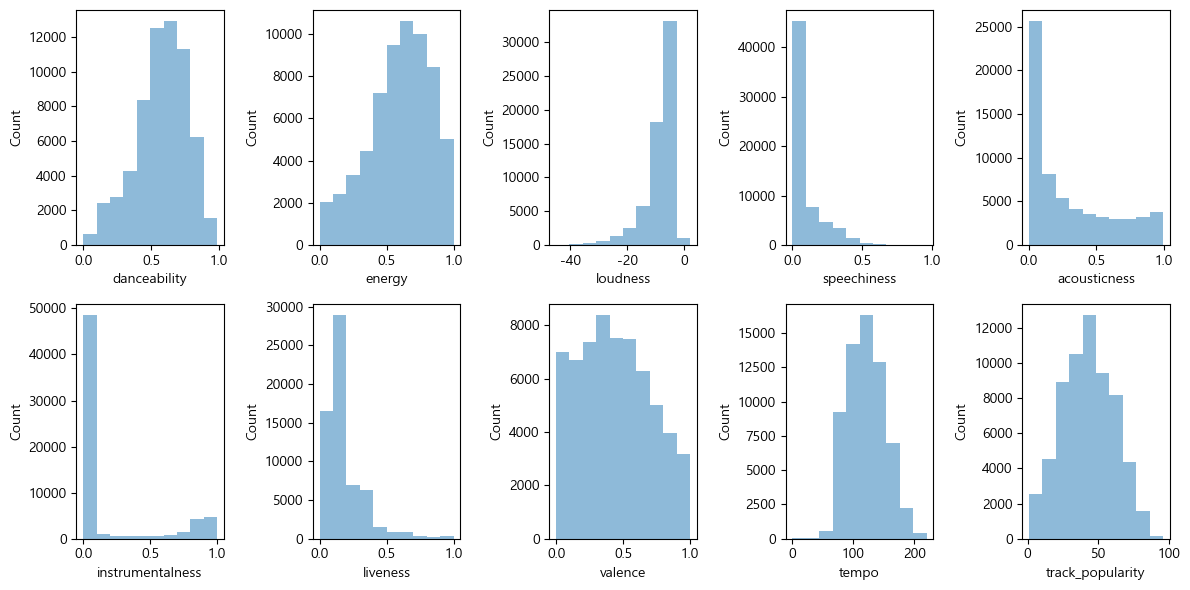

In [ ]:
show_plot(game_57817_df)

In [20]:
variables = ['speechiness', 'liveness', 'tempo', 'duration_ms', 'track_popularity', 'danceability', 'energy', 'loudness', 'acousticness', 'valence']

for var in variables:
    stat, p_value = stats.shapiro(all_57817_merge_filt2[var])
    print(f'Statistic for {var}: {stat}')
    print(f'p-value for {var}: {p_value}')
    print('---')

Statistic for speechiness: 0.7146660089492798
p-value for speechiness: 0.0
---
Statistic for liveness: 0.7425969839096069
p-value for liveness: 0.0
---
Statistic for tempo: 0.9865356683731079
p-value for tempo: 0.0
---
Statistic for duration_ms: 0.9928646087646484
p-value for duration_ms: 4.526194039769159e-43
---
Statistic for track_popularity: 0.9951257705688477
p-value for track_popularity: 5.590442332313382e-37
---
Statistic for danceability: 0.9851590394973755
p-value for danceability: 0.0
---
Statistic for energy: 0.9726588726043701
p-value for energy: 0.0
---
Statistic for loudness: 0.7661647796630859
p-value for loudness: 0.0
---
Statistic for acousticness: 0.8324540853500366
p-value for acousticness: 0.0
---
Statistic for valence: 0.9764809608459473
p-value for valence: 0.0
---


In [29]:
variables = ['speechiness', 'liveness', 'tempo', 'duration_ms', 'track_popularity', 'danceability', 'energy', 'loudness', 'acousticness', 'valence']

for var in variables:
    stat, p_value = stats.shapiro(game_detail_merge_filt2[var])
    print(f'Statistic for {var}: {stat}')
    print(f'p-value for {var}: {p_value}')
    print('---')

Statistic for speechiness: 0.4794986844062805
p-value for speechiness: 0.0
---
Statistic for liveness: 0.6809206008911133
p-value for liveness: 0.0
---
Statistic for tempo: 0.981232762336731
p-value for tempo: 4.8162284746913684e-33
---
Statistic for duration_ms: 0.9492537975311279
p-value for duration_ms: 0.0
---
Statistic for track_popularity: 0.9765767455101013
p-value for track_popularity: 3.3306320187405196e-36
---
Statistic for danceability: 0.9671369194984436
p-value for danceability: 2.522477365631103e-41
---
Statistic for energy: 0.9493268132209778
p-value for energy: 0.0
---
Statistic for loudness: 0.9765703082084656
p-value for loudness: 3.299866768795186e-36
---
Statistic for acousticness: 0.8819725513458252
p-value for acousticness: 0.0
---
Statistic for valence: 0.801200270652771
p-value for valence: 0.0
---


c:\Users\Medici\miniconda3\envs\data_analysis\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


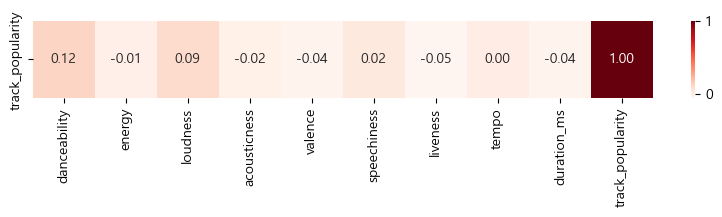

In [40]:
corr_1000 = all_57817_merge_filt2[[ 'danceability', 'energy', 'loudness', 'acousticness', 'valence', 'speechiness', 'liveness', 'tempo', 'duration_ms', 'track_popularity']].corr()
plt.figure(figsize=(10, 1))
ax = sns.heatmap(corr_1000[-1:], annot=True, fmt='.2f',cmap='Reds')

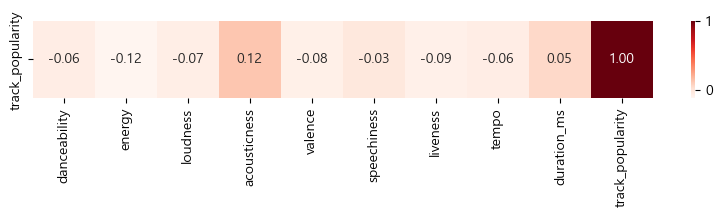

In [50]:
corr_1000 = game_detail_merge_filt2[[ 'danceability', 'energy', 'loudness', 'acousticness', 'valence', 'speechiness', 'liveness', 'tempo', 'duration_ms', 'track_popularity']].corr()
plt.figure(figsize=(10, 1))
ax = sns.heatmap(corr_1000[-1:], annot=True, fmt='.2f',cmap='Reds')

In [46]:
# Extract columns for endog and exog variables
endog = all_57817_merge_filt2['track_popularity']
exog_cols = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'duration_ms']
exog = all_57817_merge_filt2[exog_cols]

# Add constant column to exog
exog = sm.add_constant(exog)

# Fit the OLS model
model_group = sm.OLS(endog, exog).fit()
print(model_group.summary())

                            OLS Regression Results                            
Dep. Variable:       track_popularity   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     269.6
Date:                Fri, 02 Jun 2023   Prob (F-statistic):               0.00
Time:                        12:47:35   Log-Likelihood:            -2.2675e+05
No. Observations:               53773   AIC:                         4.535e+05
Df Residuals:                   53763   BIC:                         4.536e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               56.1175      0.779  

In [47]:
# Extract results from the model
adjusted_r_squared = model_group.rsquared_adj
f_statistic = model_group.fvalue
p_value = model_group.f_pvalue

# Create a dictionary with the values
data = {
    'Adjusted R-squared': adjusted_r_squared,
    'F-Statistic': f_statistic,
    'P-Value': p_value
}

# Convert the dictionary to a DataFrame
results_df = pd.DataFrame(data, index=['']).round(4)

# Print the results DataFrame
results_df

,Adjusted R-squared,F-Statistic,P-Value
,0.043,269.6464,0.0


In [ ]:
# Extract results from the model
adjusted_r_squared = model_group.rsquared_adj
f_statistic = model_group.fvalue
p_value = model_group.f_pvalue

# Create a dictionary with the values
data = {
    'Adjusted R-squared': adjusted_r_squared,
    'F-Statistic': f_statistic,
    'P-Value': p_value
}

# Convert the dictionary to a DataFrame
results_df = pd.DataFrame(data, index=['']).round(4)

# Print the results DataFrame
results_df

In [35]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

pd.DataFrame({'컬럼':column, 
              'VIF': variance_inflation_factor(model_group.model.exog, i)} for i, column in enumerate(model_group.model.exog_names) if column != 'const')

,컬럼,VIF
0,danceability,1.512090
1,energy,3.243918
2,loudness,2.918370
3,speechiness,1.143161
4,acousticness,1.840646
5,instrumentalness,1.433729
6,liveness,1.066876
7,valence,1.497435
8,duration_ms,1.100304


In [55]:
# Extract columns for endog and exog variables
endog = game_detail_merge_filt2['track_popularity']
exog_cols = [ 'energy', 'loudness',  'acousticness', 'instrumentalness', 'liveness', 'duration_ms']
exog = game_detail_merge_filt2[exog_cols]

# Add constant column to exog
exog = sm.add_constant(exog)

# Fit the OLS model
model_group = sm.OLS(endog, exog).fit()
print(model_group.summary())

                            OLS Regression Results                            
Dep. Variable:       track_popularity   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     36.91
Date:                Fri, 02 Jun 2023   Prob (F-statistic):           1.81e-44
Time:                        14:01:19   Log-Likelihood:                -36082.
No. Observations:                9167   AIC:                         7.218e+04
Df Residuals:                    9160   BIC:                         7.223e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               24.2204      1.067  

In [56]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

pd.DataFrame({'컬럼':column, 
              'VIF': variance_inflation_factor(model_group.model.exog, i)} for i, column in enumerate(model_group.model.exog_names) if column != 'const')

,컬럼,VIF
0,energy,3.826327
1,loudness,2.801776
2,acousticness,2.020792
3,instrumentalness,1.082701
4,liveness,1.081901
5,duration_ms,1.007031


In [32]:
# 카이제곱 검정 수행
contingency_table = pd.crosstab(game_57817_df['대중음악'], game_57817_df['게임음악'])
chi2, p_value, _, _ = chi2_contingency(contingency_table)

# 결과 출력
print("Chi-square statistic:", chi2)
print("p-value:", p_value)

Chi-square statistic: 62931.96384849215
p-value: 0.0


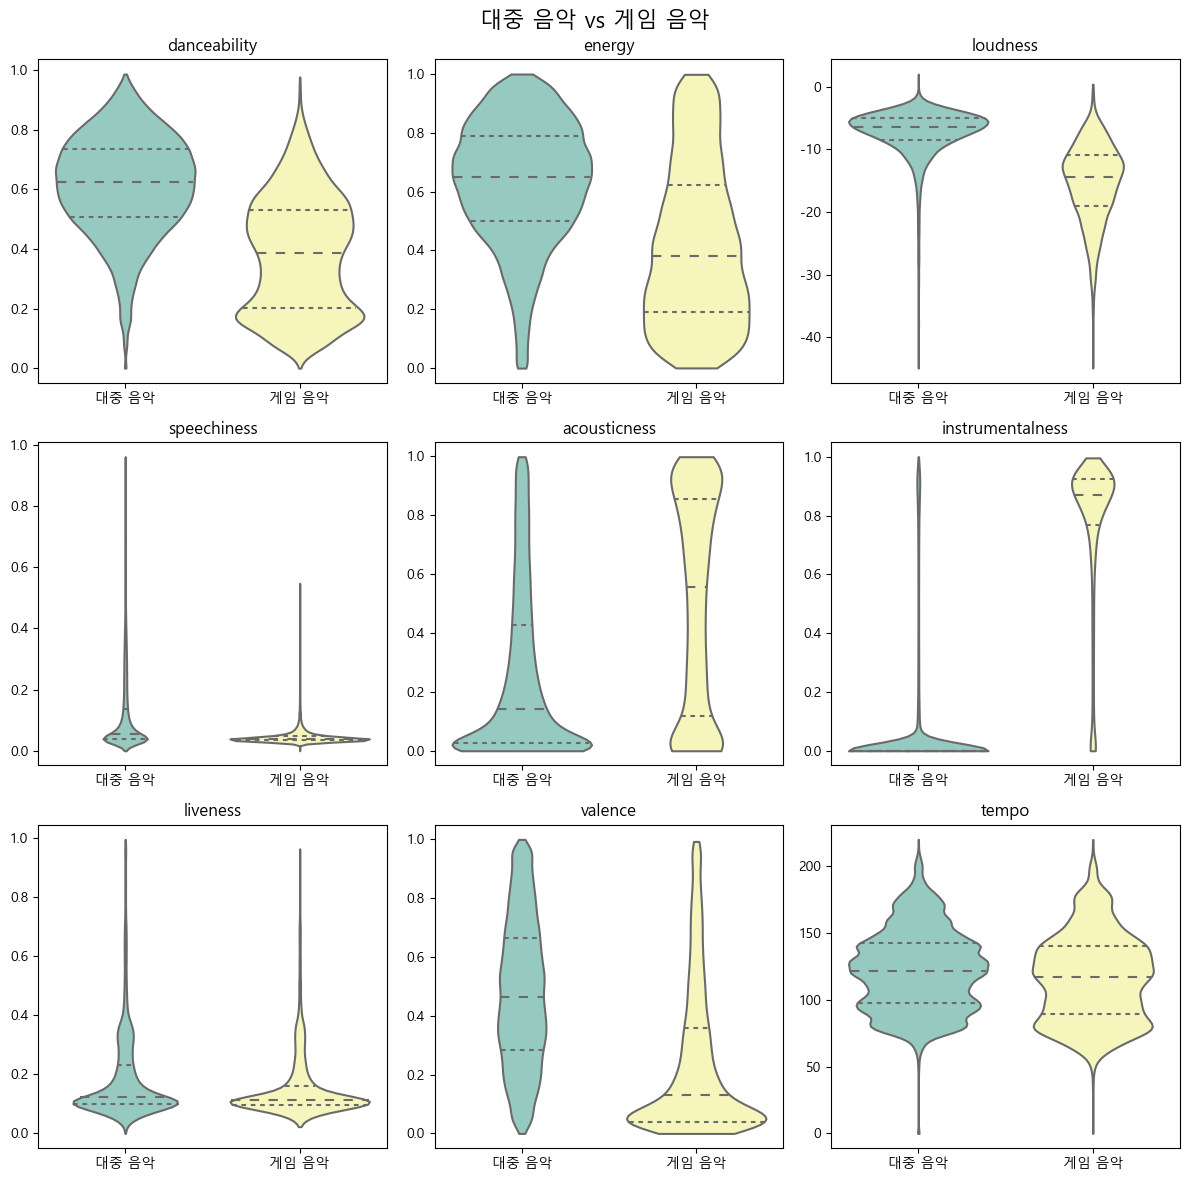

In [ ]:
# List of features
features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

# Flatten the axes array to easily access individual subplots
axes = axes.flatten()

# Iterate over each feature
for i, feature in enumerate(features):
    # Get the current axis
    ax = axes[i]

    # Create feature values for each category
    feature_values = [all_57817_merge_filt2[feature].values, game_detail_merge_filt2[feature].values]
    labels = ['대중 음악', '게임 음악']

    # Create the violin plot
    sns.violinplot(data=feature_values, palette="Set3", inner="quartile", cut=0, ax=ax)
    ax.set_xticklabels(labels)
    ax.set_title(f"{feature}")

# Remove any extra subplots
if len(features) < len(axes):
    for j in range(len(features), len(axes)):
        fig.delaxes(axes[j])

# Adjust the spacing between subplots
fig.suptitle("대중 음악 vs 게임 음악", fontsize=16)
fig.tight_layout()

# Show the plot
plt.show()

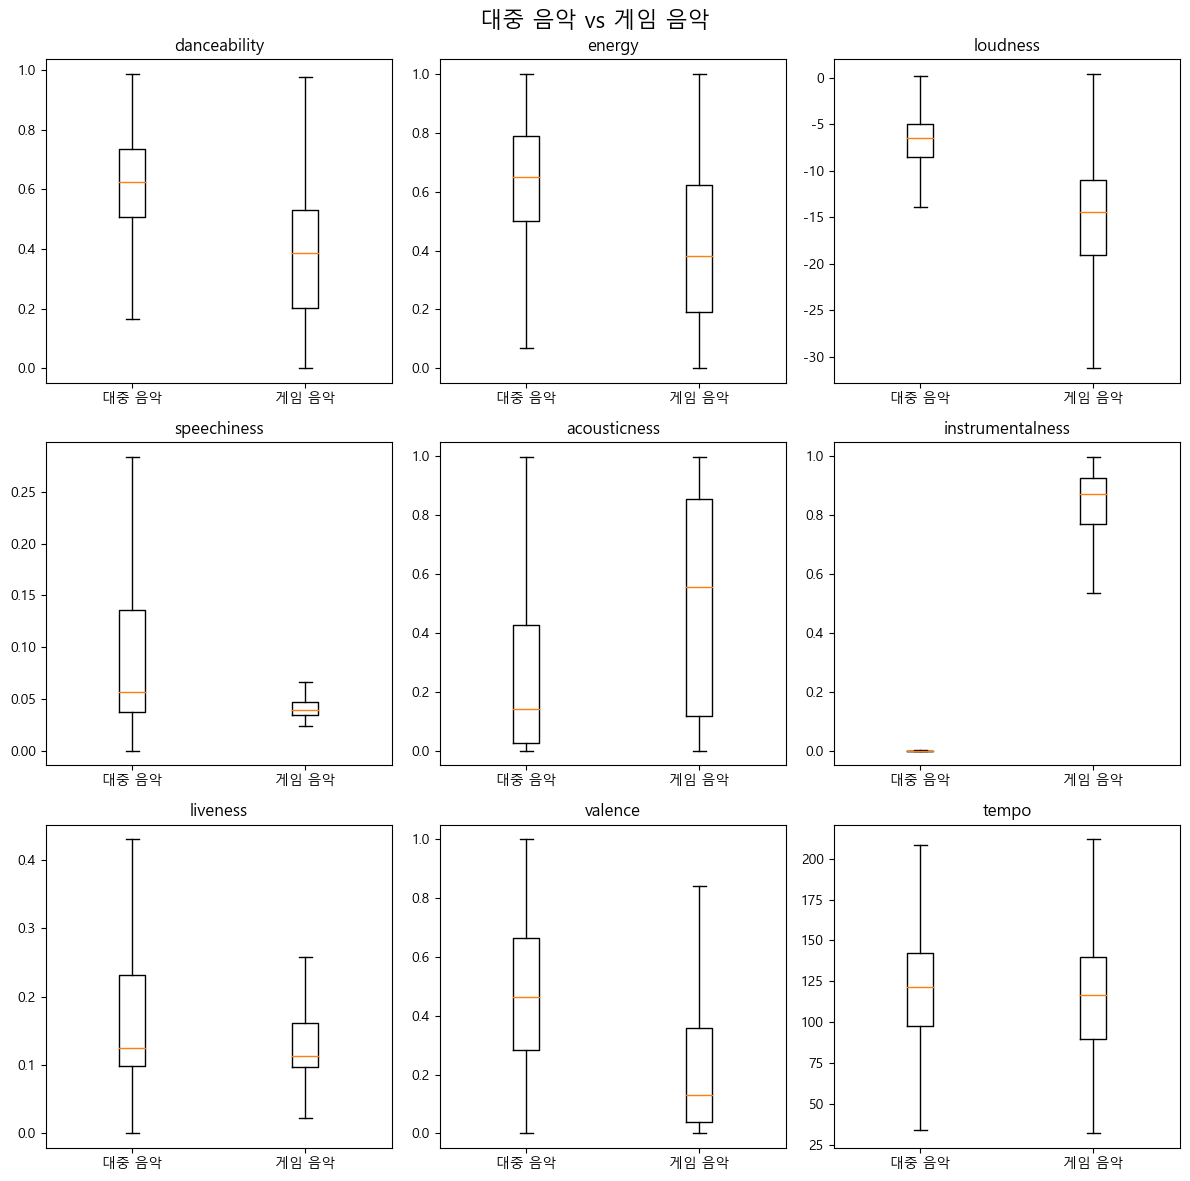

In [53]:
# List of features
features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

# Flatten the axes array to easily access individual subplots
axes = axes.flatten()

# Iterate over each feature
for i, feature in enumerate(features):
    # Get the current axis
    ax = axes[i]

    # Create feature values for each category
    feature_values = [all_57817_merge_filt2[feature].values, game_detail_merge_filt2[feature].values]
    labels = ['대중 음악', '게임 음악']

    # Create the box plot
    ax.boxplot(feature_values, labels=labels, showfliers=False)

    # Set the title
    ax.set_title(feature)

# Remove any extra subplots
if len(features) < len(axes):
    for j in range(len(features), len(axes)):
        fig.delaxes(axes[j])

# Adjust the spacing between subplots
fig.suptitle("대중 음악 vs 게임 음악", fontsize=16)
fig.tight_layout()

# Show the plot
plt.show()

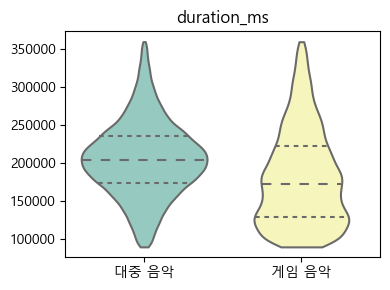

In [ ]:
# Create a 3x3 grid of subplots
fig, ax = plt.subplots( figsize=(4, 3))

# Create feature values for each category
feature_values = [all_57817_merge_filt2['duration_ms'].values, game_detail_merge_filt2['duration_ms'].values]
labels = ['대중 음악', '게임 음악']

# Create the violin plot
sns.violinplot(data=feature_values, palette="Set3", inner="quartile", cut=0, ax=ax)
ax.set_xticklabels(labels)
ax.set_title(f"{'duration_ms'}")


# Adjust the spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()

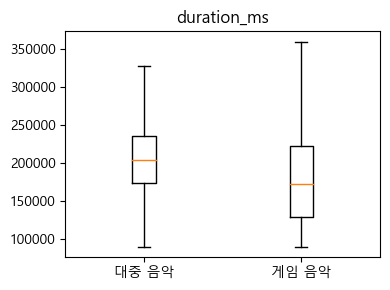

In [54]:
# Create a 1x1 subplot
fig, ax = plt.subplots(figsize=(4, 3))

# Create feature values for each category
feature_values = [all_57817_merge_filt2['duration_ms'].values, game_detail_merge_filt2['duration_ms'].values]
labels = ['대중 음악', '게임 음악']

# Create the box plot
ax.boxplot(feature_values, labels=labels, showfliers=False)

# Set the title
ax.set_title('duration_ms')

# Adjust the spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()


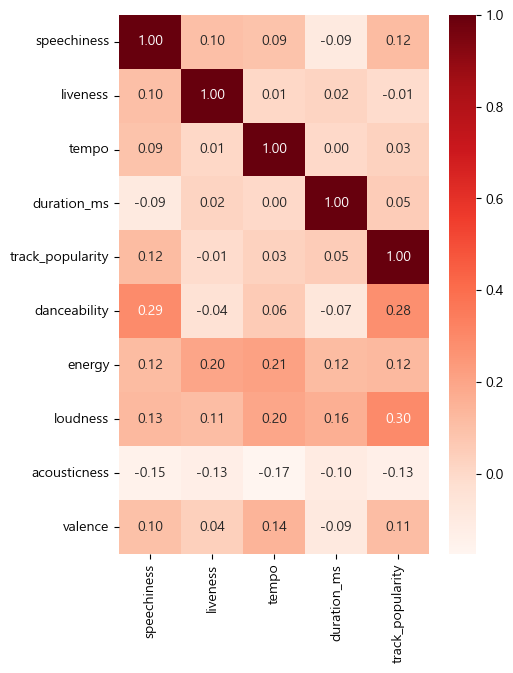

In [ ]:
corr_1000 = game_57817_df[['speechiness', 'liveness', 'tempo', 'duration_ms', 'track_popularity', 'danceability', 'energy', 'loudness', 'acousticness', 'valence']].corr()
plt.figure(figsize=(5, 7))
ax = sns.heatmap(corr_1000[['speechiness', 'liveness', 'tempo', 'duration_ms', 'track_popularity']], annot=True, fmt='.2f',cmap='Reds')

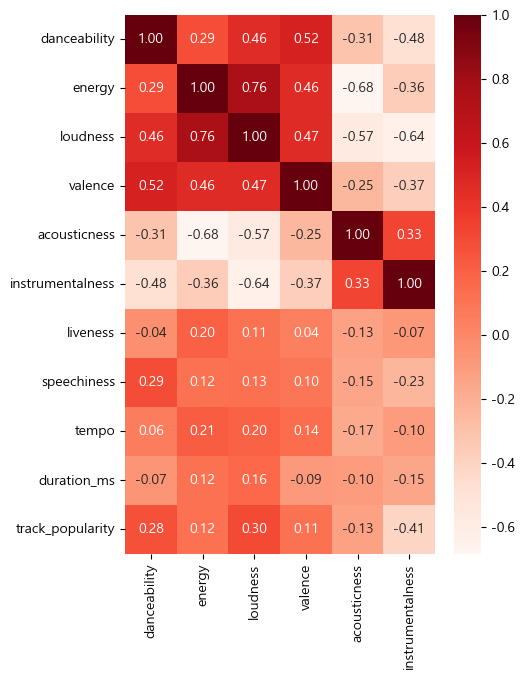

In [ ]:
corr_1000 = game_57817_df[['danceability', 'energy', 'loudness', 'valence','acousticness', 'instrumentalness', 'liveness', 'speechiness', 'tempo', 'duration_ms', 'track_popularity']].corr()
plt.figure(figsize=(5, 7))
ax = sns.heatmap(corr_1000[['danceability', 'energy', 'loudness','valence','acousticness', 'instrumentalness']], annot=True, fmt='.2f',cmap='Reds')

### 두 집단의 차이가 유의미한가?

In [ ]:
features2 = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'duration_ms', 'tempo']
for feature in features2:
    feature_values = [all_57817_merge_filt2[feature].values, game_detail_merge_filt2[feature].values]
    _, p_value = ttest_ind(feature_values[0], feature_values[1])
    
    if p_value < 0.05:
        print(f'{feature}는 차이가 유의미하다. p_value: {p_value:.05f}')
    else:
        print(f'{feature}는 차이가 유의미하지 않다. p_value: {p_value:.05f}')


danceability는 차이가 유의미하다. p_value: 0.00000
energy는 차이가 유의미하다. p_value: 0.00000
loudness는 차이가 유의미하다. p_value: 0.00000
speechiness는 차이가 유의미하다. p_value: 0.00000
acousticness는 차이가 유의미하다. p_value: 0.00000
instrumentalness는 차이가 유의미하다. p_value: 0.00000
liveness는 차이가 유의미하다. p_value: 0.00000
valence는 차이가 유의미하다. p_value: 0.00000
duration_ms는 차이가 유의미하다. p_value: 0.00000
tempo는 차이가 유의미하다. p_value: 0.00000


C:\Users\LeeJinho\AppData\Local\Temp\ipykernel_19588\3257793765.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_1000 = game_57817_df.corr()


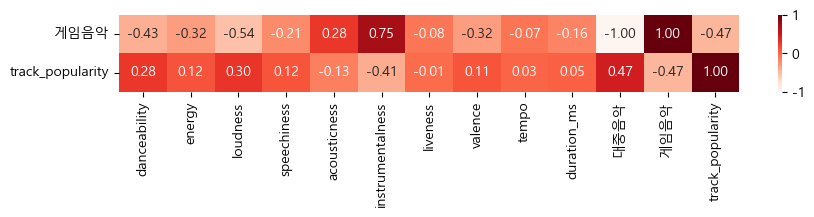

In [ ]:
corr_1000 = game_57817_df.corr()
plt.figure(figsize=(10, 1))
ax = sns.heatmap(corr_1000[-2:], annot=True, fmt='.2f',cmap='Reds')

In [ ]:
# Extract columns for endog and exog variables
endog = game_57817_df['track_popularity']
exog_cols = ['대중음악']
exog = game_57817_df[exog_cols]

# Add constant column to exog
exog = sm.add_constant(exog)

# Fit the OLS model
model_group = sm.OLS(endog, exog).fit()
print(model_group.summary())

                            OLS Regression Results                            
Dep. Variable:       track_popularity   R-squared:                       0.218
Model:                            OLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                 1.752e+04
Date:                Thu, 01 Jun 2023   Prob (F-statistic):               0.00
Time:                        22:51:17   Log-Likelihood:            -2.6471e+05
No. Observations:               62940   AIC:                         5.294e+05
Df Residuals:                   62938   BIC:                         5.294e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         21.7644      0.170    128.403      0.0

In [41]:
# Extract columns for endog and exog variables
endog = game_57817_df['track_popularity']
exog_cols = ['대중음악','danceability', 'energy', 'loudness',
            'acousticness', 'instrumentalness', 'liveness', 'valence', 'duration_ms']
exog = game_57817_df[exog_cols]

# Add constant column to exog
exog = sm.add_constant(exog)

# Fit the OLS model
model_group = sm.OLS(endog, exog).fit()
print(model_group.summary())

                            OLS Regression Results                            
Dep. Variable:       track_popularity   R-squared:                       0.245
Model:                            OLS   Adj. R-squared:                  0.245
Method:                 Least Squares   F-statistic:                     2266.
Date:                Fri, 02 Jun 2023   Prob (F-statistic):               0.00
Time:                        11:24:24   Log-Likelihood:            -2.6360e+05
No. Observations:               62940   AIC:                         5.272e+05
Df Residuals:                   62930   BIC:                         5.273e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               35.7147      0.697  

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

pd.DataFrame({'컬럼':column, 
              'VIF': variance_inflation_factor(model_group.model.exog, i)} for i, column in enumerate(model_group.model.exog_names) if column != 'const')

,컬럼,VIF
0,대중음악,2.358226
1,danceability,1.734779
2,energy,3.709915
3,loudness,3.884197
4,acousticness,2.020679
5,instrumentalness,2.955762
6,liveness,1.060381
7,valence,1.706172
8,duration_ms,1.100495


In [44]:
# Extract columns for endog and exog variables
endog = game_57817_df['대중음악']
exog_cols = ['track_popularity','danceability', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'duration_ms', 'tempo']
exog = game_57817_df[exog_cols]

# Add constant column to exog
exog = sm.add_constant(exog)

# Fit the OLS model
model_group = sm.OLS(endog, exog).fit()
print(model_group.summary())

                            OLS Regression Results                            
Dep. Variable:                   대중음악   R-squared:                       0.605
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     9644.
Date:                Fri, 02 Jun 2023   Prob (F-statistic):               0.00
Time:                        11:25:22   Log-Likelihood:                 5516.6
No. Observations:               62940   AIC:                        -1.101e+04
Df Residuals:                   62929   BIC:                        -1.091e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.6835      0.008  

In [45]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

pd.DataFrame({'컬럼':column, 
              'VIF': variance_inflation_factor(model_group.model.exog, i)} for i, column in enumerate(model_group.model.exog_names) if column != 'const')

,컬럼,VIF
0,track_popularity,1.232776
1,danceability,1.773203
2,loudness,2.568002
3,speechiness,1.164525
4,acousticness,1.545262
5,instrumentalness,2.043248
6,liveness,1.050188
7,valence,1.572360
8,duration_ms,1.105922
9,tempo,1.064618


# 번외

In [ ]:
genre_details = pd.read_csv('genre_details_v3.CSV')
vibe_details = pd.read_csv('vibe_details_v3.CSV')

In [ ]:
genre_details_filt = detail_filt(genre_details)
vibe_details_filt = detail_filt(vibe_details)

In [ ]:
genres = [ 'RPG', '공포', '로그라이크', '배틀로얄', '생존', '스토리', '스포츠', '슈팅', '시뮬레이션', '액션', '어드벤쳐', '잠입', '전략', '퍼즐', '플랫포머']

vibes = ['SF', '공포', '귀여운', '근현대', '다크판타지', '동양', '릴랙싱', '미스터리', '복고풍', '신화', '아포칼립스', '애니메이션', '유머', '중세', '판타지', '펑크', '현대']

genre_details = {}
for genre in genres:
    genre_details[f'{genre}_details'] = genre_details_filt[genre_details_filt[genre] == 1]
  
vibe_details = {}  
for vibe in vibes:
    vibe_details[f'{vibe}_details'] = vibe_details_filt[vibe_details_filt[vibe] == 1]

In [ ]:
joined_df = genre_details_filt.merge(vibe_details_filt[['album_track', 'SF', '공포', '귀여운', '근현대', '다크판타지', '동양', '릴랙싱', '미스터리', '복고풍', '신화', '아포칼립스', '애니메이션', '유머', '중세', '판타지', '펑크', '현대']], on='album_track')
joined_df.keys()

Index(['album_track', 'track_name', 'album_id', 'album_name', 'RPG', '공포_x',
       '로그라이크', '배틀로얄', '생존', '스토리', '스포츠', '슈팅', '시뮬레이션', '액션', '어드벤쳐', '잠입',
       '전략', '퍼즐', '플랫포머', 'danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'track_popularity', 'SF', '공포_y', '귀여운', '근현대', '다크판타지',
       '동양', '릴랙싱', '미스터리', '복고풍', '신화', '아포칼립스', '애니메이션', '유머', '중세', '판타지',
       '펑크', '현대'],
      dtype='object')

In [ ]:
desired_order = ['album_track', 'track_name', 'album_id', 'album_name', 'RPG', '공포_x',
       '로그라이크', '배틀로얄', '생존', '스토리', '스포츠', '슈팅', '시뮬레이션', '액션', '어드벤쳐', '잠입',
       '전략', '퍼즐', '플랫포머', 'SF', '공포_y', '귀여운', '근현대', '다크판타지',
       '동양', '릴랙싱', '미스터리', '복고풍', '신화', '아포칼립스', '애니메이션', '유머', '중세', '판타지',
       '펑크', '현대', 'danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'track_popularity']

joined_reindex_df = joined_df.reindex(columns=desired_order)
joined_reindex_df2 = joined_reindex_df.drop('duration_ms', axis=1)

new_column_names = {'공포_x': '공포_genre', '공포_y': '공포_vibe'}
joined_reindex_df2 = joined_reindex_df2.rename(columns=new_column_names)

joined_reindex_df2.keys()

Index(['album_track', 'track_name', 'album_id', 'album_name', 'RPG',
       '공포_genre', '로그라이크', '배틀로얄', '생존', '스토리', '스포츠', '슈팅', '시뮬레이션', '액션',
       '어드벤쳐', '잠입', '전략', '퍼즐', '플랫포머', 'SF', '공포_vibe', '귀여운', '근현대',
       '다크판타지', '동양', '릴랙싱', '미스터리', '복고풍', '신화', '아포칼립스', '애니메이션', '유머', '중세',
       '판타지', '펑크', '현대', 'danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'track_popularity'],
      dtype='object')

In [ ]:
# Handle missing values
joined_reindex_df2.dropna(inplace=True)

# Handle infinite or NaN values
joined_reindex_df2 = joined_reindex_df2.replace([np.inf, -np.inf], np.nan)
joined_reindex_df2.dropna(inplace=True)

In [ ]:
endog = joined_reindex_df2['track_popularity']
exog_cols = ['로그라이크', '스토리', '스포츠', '시뮬레이션',
             '어드벤쳐', '잠입', '전략', '플랫포머', 'SF', '공포_vibe', '귀여운', '근현대',
            '미스터리', '복고풍', '신화', '아포칼립스', '애니메이션', '판타지', '펑크', '현대', 'energy', 'loudness',  'acousticness',  'liveness', 'tempo']
exog = joined_reindex_df2[exog_cols]

# Add constant column to exog
exog = sm.add_constant(exog)

# Fit the OLS model
model_group = sm.OLS(endog, exog).fit()
print(model_group.summary())

                            OLS Regression Results                            
Dep. Variable:       track_popularity   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     41.67
Date:                Fri, 02 Jun 2023   Prob (F-statistic):          4.97e-191
Time:                        03:03:52   Log-Likelihood:                -31619.
No. Observations:                8136   AIC:                         6.329e+04
Df Residuals:                    8110   BIC:                         6.347e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           20.9906      1.122     18.714   

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

pd.DataFrame({'컬럼':column, 
              'VIF': variance_inflation_factor(model_group.model.exog, i)} for i, column in enumerate(model_group.model.exog_names) if column != 'const')

,컬럼,VIF
0,로그라이크,1.089566
1,스토리,1.108102
2,스포츠,1.170307
3,시뮬레이션,1.049513
4,어드벤쳐,1.343862
5,잠입,1.395534
6,전략,1.360404
7,플랫포머,1.811972
8,SF,1.821135
9,공포_vibe,1.166010
